#### Examine the daily data extracted by `get_data.py.`

Loads all the files in the input/ directory.

Plots:
1. Histograms of the overall distributions of wind speed, 30-day rainfall, and wind direction.
2. Sample plots of wind speed, 30-day rainfall, and wind direction for random time steps.
3. Average wind speed, 30-day rainfall, and wind direction over all time.
4. Other statistics (min, max, std) of wind speed and 30-day rainfall.
5. Wind rose plot of wind direction and speed.

In [180]:
# setup
import os
import glob
import yaml

# for analysis
import numpy as np
import xarray as xr

# for plotting
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from windrose import WindroseAxes
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = ["serif", "sans-serif", "monospace"][0]

SUBSET_YEAR = ["*", "17"][0]

wd = "hazGAN2/projects/poweruk_winter"
figdir = os.path.join(wd, "results", "figures", "eda")
os.makedirs(figdir, exist_ok=True)

In [181]:
# required functions

def check_missing_days(ds):
    all_days = np.arange(ds.time.min().values, ds.time.max().values + np.timedelta64(1, 'D'), dtype='datetime64[D]')
    missing_days = np.setdiff1d(all_days, ds.time.values)
    if len(missing_days) > 0:
        print(f"Missing days: {len(missing_days)}")
        print(missing_days)
    else:
        print("No missing days found.")


def handle_expver(ds):
    for coord in ["expver", "number"]:
        if coord in ds.dims:
            ds = ds.sel({coord: ds[coord][0]})
        if coord in ds.coords:
            ds = ds.reset_coords(coord, drop=True)
    return ds



def direction(ds:xr.Dataset, u:str, v:str,
              params={}
              ) -> xr.DataArray:
    """
    Calculate meteorological wind direction from ERA5 u and v components.
    
    Returns direction wind is coming FROM in degrees:
    - 0° = northerly (wind from north)
    - 90° = easterly (wind from east)  
    - 180° = southerly (wind from south)
    - 270° = westerly (wind from west)

    See:
    - https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398
    - https://numpy.org/doc/2.2/reference/generated/numpy.arctan2.html
    """
    u = ds[u]
    v = ds[v]
    direction = (180 + 180 / np.pi * np.arctan2(v, u)) % 360
    return direction


def derive_variables(ds):
    """
    Derive variables from the dataset.
    """
    ds = handle_expver(ds)
    
    # Calculate wind speed and direction
    ds["vx"] = np.sqrt(ds.u10_gust**2 + ds.v10_gust**2)
    ds["dx"] = direction(ds, "u10_gust", "v10_gust")

    return ds


def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.
    https://tobiasraabe.github.io/post/matplotlib-for-publications/

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    return fig_width_in, fig_height_in

In [182]:
with open(os.path.join(wd, "config.yaml"), "r") as stream:
    config = yaml.safe_load(stream)

ds_files = glob.glob(os.path.join(wd, "results", "processing", "input", f"20{SUBSET_YEAR}.nc"))
print(f"Found {len(ds_files)} files in the input directory.")

ds = xr.open_mfdataset(ds_files)
ds = ds.sortby(["latitude", "longitude"])

check_missing_days(ds)
ds = handle_expver(ds)
ds = derive_variables(ds)

Found 15 files in the input directory.
No missing days found.


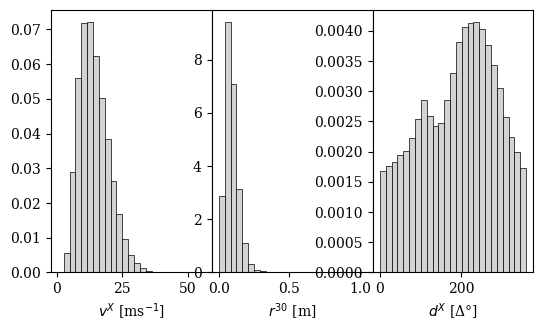

In [192]:
# %% histograms of overall distributions
fig, axs = plt.subplots(1, 3, figsize=set_size(400), gridspec_kw={"wspace":0.0})

def nice_xticks(ax, nticks=3):
    xmin, xmax = ax.get_xlim()
    ticks = np.arange(xmin, xmax, nticks)
    ax.set_xticks(ticks)

hist_kws = {"color": "lightgrey", "linewidth": 0.5, "edgecolor": "k",
            "bins": 25, "density": True}

ds.vx.plot.hist(ax=axs[0], **hist_kws)
axs[0].set_xlabel(r"$v^X$ [ms$^{-1}$]")

ds.r30.plot.hist(ax=axs[1], **hist_kws)
axs[1].set_xlabel(r"$r^{30}$ [m]")

ds.dx.plot.hist(ax=axs[2], **hist_kws)
axs[2].set_xlabel(r"$d^X$ [Δ°]")

plt.tight_layout()

fig.savefig(os.path.join(figdir, "hists.pdf"), dpi=300, transparent=True)

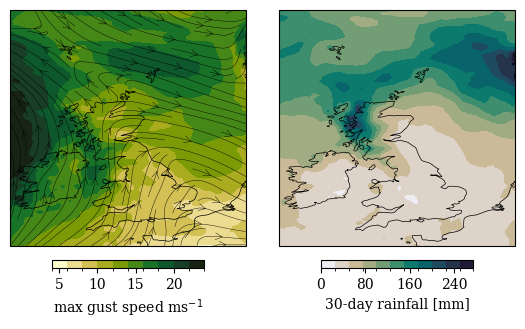

In [185]:
# %% plot some samples
from matplotlib.ticker import MaxNLocator

nrows = 1

fig, axes = plt.subplots(nrows, 2, subplot_kw={"projection": ccrs.PlateCarree()},
                         figsize=set_size(400)
                        )
if nrows == 1:
    axes = np.array([axes])

for row in range(nrows):
    axs = axes[row, :]
    t = np.random.randint(0, ds.sizes["time"])

    cbar1 = ds.isel(time=t).vx.plot.contourf(ax=axs[0], cmap=cmo.speed, levels=12,
                                     cbar_kwargs={"label": r"max gust speed ms$^{-1}$", "shrink": 0.6, "orientation": "horizontal", "pad": 0.05})
    
    cbar2 = (ds.isel(time=t).r30 * 1000).plot.contourf(ax=axs[1], cmap=cmo.rain, levels=12, cbar_kwargs={"label": "30-day rainfall [mm]", "shrink": 0.6, "orientation": "horizontal", "pad": 0.05})

    cbar1.colorbar.ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    cbar2.colorbar.ax.xaxis.set_major_locator(MaxNLocator(nbins=4))

    resample = ds.isel(time=t, longitude=slice(None, None, 7), latitude=slice(None, None, 7))
    resample.plot.streamplot(x='longitude', y='latitude', u='u10_gust', v='v10_gust', 
                                transform=ccrs.PlateCarree(), color="k", ax=axs[0], density=1.0,
                                linewidth=0.3, arrowstyle='->', arrowsize=1.25
                                )
    for ax in axs:
        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.5)
        ax.set_extent([
            ds.longitude.min().values,
            ds.longitude.max().values,
            ds.latitude.min().values,
            ds.latitude.max().values
        ])

    time_str = ds.time[t].values.astype("datetime64[s]").astype(str)
    axs[0].set_title("")
    axs[1].set_title("")

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(figdir, f"sample_{time_str}.pdf"), dpi=300, transparent=True)


In [189]:
time_str

'2009-03-13T00:00:00'

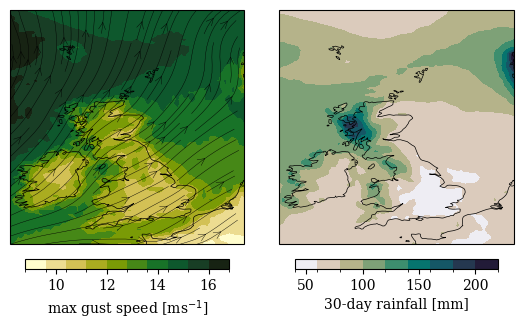

In [186]:
# %% visualise median over all time

streamline_resample = 7

ds_mean = ds.median(dim="time")

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": ccrs.PlateCarree()},
                        figsize=set_size(400), sharex=True, sharey=True)

cbar1 = ds_mean.vx.plot.contourf(ax=axs[0], cmap=cmo.speed, levels=12, cbar_kwargs={
    "label": r"max gust speed [ms$^{-1}$]", "shrink": 0.8, "orientation": "horizontal", "pad": 0.05
})
cbar2 = (ds_mean.r30 * 1000).plot.contourf(ax=axs[1], cmap=cmo.rain, levels=12, cbar_kwargs={
    "label": "30-day rainfall [mm]", "shrink": 0.8, "orientation": "horizontal", "pad": 0.05
    })

cbar1.colorbar.ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
cbar2.colorbar.ax.xaxis.set_major_locator(MaxNLocator(nbins=4))

resample = ds_mean.isel(longitude=slice(None, None, streamline_resample), latitude=slice(None, None, streamline_resample))

streamlines = resample.plot.streamplot(x='longitude', y='latitude', u='u10_gust', v='v10_gust', 
                            transform=ccrs.PlateCarree(), color="k", ax=axs[0], density=1.0,
                            linewidth=0.3, arrowstyle='->', arrowsize=1.25
                            )
for ax in axs:
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.5)
    ax.set_extent([
        ds_mean.longitude.min().values,
        ds_mean.longitude.max().values,
        ds_mean.latitude.min().values,
        ds_mean.latitude.max().values
    ])


plt.tight_layout()
plt.show()

fig.savefig(os.path.join(figdir, "climatology.pdf"), dpi=300, transparent=True)


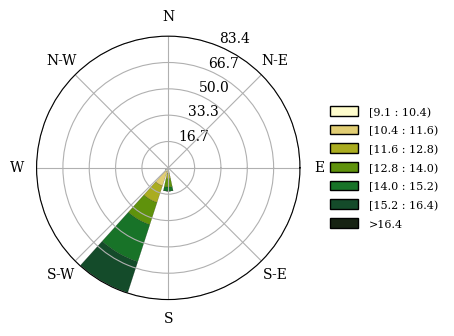

In [188]:
# %% wind rose overall etc.
fig, ax = plt.subplots(figsize=set_size(400), subplot_kw=dict(projection='windrose'))

ds_agg = ds.chunk(dict(time=-1)).quantile(0.5, dim="time")
# ds_agg = ds.mean(dim="time")

dirs = ds_agg.dx.values.flatten()
speeds = ds_agg.vx.values.flatten()

ax.bar(dirs, speeds,
       normed=True, opening=0.8,
       edgecolor='k',
       nsector=12, bins=7,
       cmap=cmo.speed,
       linewidth=0.1
      )
ax.set_legend(**{"loc": "center left", "bbox_to_anchor": (1.1, 0.5), "frameon": False});

fig.savefig(os.path.join(figdir, "windrose.pdf"), dpi=300, transparent=True)
